In [1]:
import operator
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql.functions import col
import numpy as np
# Uncomment the following line to install networkx
# !pip install networkx
import networkx as nx
from matplotlib import pyplot as plt

%matplotlib inline

In [2]:
sc = SparkContext(master="local[*]", appName="Decision Tree")
sqlContext = SQLContext(sc)
attr_name_info_gain = {}
G = nx.DiGraph()

In [3]:
attrs = ["gender","lover","gpa","laptop"]
attrs_type = {"gender":"string","lover":"string","gpa":"string","laptop":"string"}

In [4]:
def calculate_info_gain(entropy, joined_df, total_elements):
    attr_entropy = 0.0
    for anAttributeData in joined_df.rdd.collect():
        yes_class_count = anAttributeData[1]
        no_class_count = anAttributeData[2]
        if yes_class_count is None:
            yes_class_count = 0
        elif no_class_count is None:
            no_class_count = 0

        count_of_class = yes_class_count + no_class_count
        classmap = {'a' : yes_class_count, 'u' : no_class_count}
        attr_entropy = attr_entropy + ((count_of_class / total_elements) *\
                                       calculate_entropy(count_of_class, classmap))

    gain = entropy - attr_entropy

    return gain

In [5]:
def get_attr_info_gain_data_prep(attr_name, data, entropy, total_elements, where_condition):

    if not where_condition:
        attr_grp_y = data.where(col('destination') == 'a').groupBy(attr_name).agg({"destination": 'count'})\
            .withColumnRenamed('count(destination)','played_count')
    else:
        attr_grp_y = data.where(" destination like '%a%'  " + where_condition).groupBy(attr_name).agg({"destination": 'count'})\
            .withColumnRenamed('count(destination)','played_count')

    if not where_condition:
        attr_grp_n = data.where(col('destination') == 'u').groupBy(attr_name).agg({"destination": 'count'})\
            .withColumnRenamed(attr_name,'n_' + attr_name)\
            .withColumnRenamed('count(destination)','not_played_count')
    else:
        attr_grp_n = data.where(" destination like '%u%'  " + where_condition).groupBy(attr_name).agg({"destination": 'count'})\
            .withColumnRenamed(attr_name,'n_' + attr_name)\
            .withColumnRenamed('count(destination)','not_played_count')

    joined_df = attr_grp_y.join(attr_grp_n, on = [col(attr_grp_y.columns[0]) == col(attr_grp_n.columns[0])], how='outer' )\
        .withColumn("total", col(attr_grp_y.columns[0]) + col(attr_grp_n.columns[0]))\
        .select(attr_grp_y.columns[0], attr_grp_y.columns[1],\
                 attr_grp_n.columns[1]) \

    gain_for_attribute = calculate_info_gain(entropy, joined_df, total_elements)
    attr_name_info_gain[attr_name] = gain_for_attribute

In [6]:
def calculate_entropy(total_elements, elements_in_each_class):
    # for target set S having 2 class 0 and 1, the entropy is -p0logp0 -p1logp1
    # here the log is of base 2
    # elements_in_each_class is a dictionary where the key is class label and the
    # value is number of elements in that class
    keysInMap = list(elements_in_each_class.keys())
    entropy = 0.0

    for aKey in keysInMap:
        number_of_elements_in_class = elements_in_each_class.get(aKey)
        if number_of_elements_in_class == 0:
            continue
        ratio = number_of_elements_in_class/total_elements
        entropy = entropy - ratio * np.log2(ratio)

    return entropy

In [7]:
def process_dataset(excludedAttrs, data, played, notplayed, where_condition):
    total_elements = played + notplayed
    subs_info = {"played" : played, "notplayed" : notplayed}
    entropy = calculate_entropy(total_elements, subs_info)
    print ("entropy is " + str(entropy))
    global attr_name_info_gain
    attr_name_info_gain = dict()

    for attr in attrs:
        if attr not in excludedAttrs:
            get_attr_info_gain_data_prep(attr, data, entropy, total_elements, where_condition)

In [8]:
def build_tree(max_gain_attr, processed_attrs, data, where_condition):
    attrValues = sqlContext.sql("select distinct " + max_gain_attr + " from data  where 1==1 " + where_condition)
    orig_where_condition = where_condition

    for aValueForMaxGainAttr in attrValues.rdd.collect():
        adistinct_value_for_attr = aValueForMaxGainAttr[0]
        G.add_edges_from([(max_gain_attr, adistinct_value_for_attr)])

        if attrs_type[max_gain_attr] == "string":
            where_condition = str(orig_where_condition + " and " + max_gain_attr + "=='" + adistinct_value_for_attr + "'")
        else:
            where_condition = str(orig_where_condition + " and " + max_gain_attr + "==" + adistinct_value_for_attr)

        played_for_attr = sqlContext.sql("select * from data where destination like '%a%' " + where_condition).count()
        notplayed_for_attr = sqlContext.sql("select * from data where destination like '%u%' " + where_condition).count()
        # if either has zero value then entropy for this attr will be zero and its the last attr in the tree
        leaf_values = []
        if played_for_attr == 0 or notplayed_for_attr == 0:
            leaf_node = sqlContext.sql("select distinct destination from data where 1==1 " + where_condition)
            for leaf_node_data in leaf_node.rdd.collect():
                G.add_edges_from([(adistinct_value_for_attr, str(leaf_node_data[0]))])
            continue
        process_dataset(processed_attrs, data, played_for_attr, notplayed_for_attr, where_condition)
        if not attr_name_info_gain: # we processed all attributes
            # attach leaf node
            leaf_node = sqlContext.sql("select distinct destination from data where 1==1 " + where_condition)
            for leaf_node_data in leaf_node.rdd.collect():
                G.add_edges_from([(adistinct_value_for_attr, str(leaf_node_data[0]))])
            continue # we are done for this branch of tree

        # get the attr with max info gain under aValueForMaxGainAttr
        # sort by info gain
        sorted_by_info_gain = sorted(attr_name_info_gain.items(), key=operator.itemgetter(1), reverse=True)
        new_max_gain_attr = sorted_by_info_gain[0][0]
        if sorted_by_info_gain[0][1] == 0:
            # under this where condition, records dont have entropy
            leaf_node = sqlContext.sql("select distinct destination from data where 1==1 " + where_condition)
            # there might be more than one leaf node
            for leaf_node_data in leaf_node.rdd.collect():
                G.add_edges_from([(adistinct_value_for_attr, str(leaf_node_data[0]))])
            continue # we are done for this branch of tree

        G.add_edges_from([(adistinct_value_for_attr, new_max_gain_attr)])
        processed_attrs.append(new_max_gain_attr)
        build_tree(new_max_gain_attr, processed_attrs, data, where_condition)

entropy is 0.9612366047228759
entropy is 0.9910760598382222
entropy is 0.8112781244591328
entropy is 0.9182958340544896


C:\Users\starf\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
C:\Users\starf\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes
C:\Users\starf\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  app.launch_new_instance()


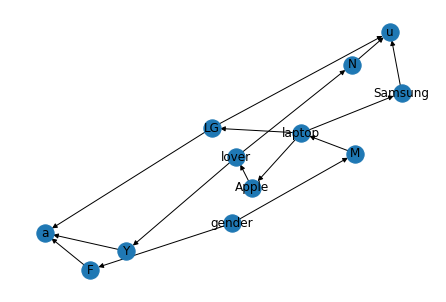

In [9]:
data = sqlContext.read.format('com.databricks.spark.csv').option('header', 'true')\
        .option('delimiter', ';').load("usau_dataset.txt")

data.registerTempTable('data')
played = sqlContext.sql("select * from data WHERE destination like  '%a%' ").count()
notplayed = sqlContext.sql("select * from data WHERE destination like  '%u%' ").count()
process_dataset([], data, played, notplayed, '')
# sort by info gain
sorted_by_info_gain = sorted(attr_name_info_gain.items(), key=operator.itemgetter(1), reverse=True)

processed_attrs = []
max_gain_attr = sorted_by_info_gain[0][0]
processed_attrs.append(max_gain_attr)
build_tree(max_gain_attr, processed_attrs, data, '')
nx.draw(G, with_labels=True)
plt.tight_layout()
plt.savefig("Graph.png", format="png")

In [10]:
sc.stop()